In [1]:
%load_ext autoreload
%autoreload 2
import glob
import matplotlib.pyplot as plt
from matplotlib import cycler
import datetime
import pandas as pd
import os
import helper
import numpy as np
import seaborn as sns
import itertools
import json

import helper


In [3]:
hotfile = "captures/campus/brawl-stars/1.1Mbps/twitch_har_iter0.har"

In [4]:


cycler_colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#CF4457', '#188487', '#E24A33']
def set_matplot_params(font_size = 8, xtick_major = 0.25, xtick_minor = 0.25, ytick_major = 0.25, ytick_minor = 0.25):
    params_dict = {
        'text.usetex': False,
        # 'font.family': 'Times New Roman',
        # 'font.serif': 'Times New Roman',
        # 'font.sans-serif': 'Times New Roman',
        'font.size': font_size,
        'figure.figsize': [3.125, 1.93],  # Golden ratio
        #figure.figsize: 3.125, 1.56  # Squash for more space
        'legend.fontsize': 6,
        'legend.fancybox': False,
        'axes.linewidth': 0.5,
        'pdf.fonttype' : 42,
        'ps.fonttype' : 42,
        'axes.prop_cycle': cycler("color", cycler_colors),
                          # 348ABD : blue
                          # A60628 : red
                          # 7A68A6 : purple
                          # 467821 : green
                          # CF4457 : pink
                          # 188487 : turquoise
                          # E24A33 : orange
        'patch.linewidth': 0.5,
        'lines.linewidth': 2,
        'grid.linewidth': 0.1,
        'xtick.major.width': xtick_major,
        'xtick.minor.width': xtick_minor,
        'ytick.major.width': ytick_major,
        'ytick.minor.width': ytick_minor,
        'legend.numpoints': 1}
    plt.rcParams.update(params_dict)
set_matplot_params()

In [5]:
# things I need
# Avg Chunk size, mean, std, median, min, max
# Number of chunks
# idle time between chunks (mean, std, median, min, max)
# video throughput

In [6]:
# Initialize an empty list to store per chunk data
per_chunk_data = []

# function to parese an har file and convert it to a csv file filtered only for video chunks
def parse_har_to_csv(har_file_path, csv_file_path):
    # Read the HAR file
    with open(har_file_path, 'r') as har_file:
        har_data = json.load(har_file)
    
    # Extract the video chunks
    # Filtering criteria for video chunks:
        # 1. The request URL ends with .ts
        # 2. The response status is 200

    video_chunks = []

    # Get the parent folder name
    parent_folder = os.path.basename(os.path.dirname(har_file_path))

    # Get the grandparent folder name
    grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(har_file_path)))

    # Get the greate grandparent folder name
    great_grandparent_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(har_file_path))))

    for entry in har_data['log']['entries']:
        request_url = entry['request']['url']
        response_status = entry['response']['status']
        if request_url.endswith('.ts') and response_status == 200:

            # Extract the chunk size
            chunk_size = entry['response']['bodySize'] * 8 / 1024 / 1024  # Convert to Megabits
            # Extract the chunk start time
            chunk_start_time = datetime.datetime.fromisoformat(entry['startedDateTime'])

            # Convert entry['time'] to seconds
            chunk_duration = datetime.timedelta(seconds=entry['time']* 0.001) 
            # Calculate the chunk end time
            chunk_end_time = (chunk_start_time + chunk_duration).isoformat()

            # Extract all of the timings data
            timings = str(entry['timings'])

            # Append the chunk to the list
            video_chunks.append({
                'start_time': chunk_start_time,
                'end_time': chunk_end_time,
                'size': chunk_size,
                'url': request_url,
                'timings': timings
            })

            per_chunk_data.append({
                'network': great_grandparent_folder,
                'category': helper.game_to_category(grandparent_folder),
                'rate': parent_folder,
                'start_time': chunk_start_time,
                'end_time': chunk_end_time,
                'total_time': chunk_duration.total_seconds(),
                'size': chunk_size,
                'url': request_url,
                'timings': timings
            })
    
    # if video chunks is empty return an item of all zeroes to it
    if len(video_chunks) == 0:
        video_chunks.append({
            'start_time': 0,
            'end_time': 0,
            'size': 0,
            'url': 0,
            'timings': 0
        })
        
    # Convert the video chunks to a DataFrame
    df = pd.DataFrame(video_chunks)
    
    # Save the DataFrame to a CSV file
    df.to_csv(csv_file_path, index=False)
            
parse_har_to_csv(hotfile, "temp.csv")


FileNotFoundError: [Errno 2] No such file or directory: 'captures/campus/brawl-stars/1.1Mbps/twitch_har_iter0.har'

In [6]:
# given a the csv file created above, write a function to calculate the metrics:
    # Chunk size: Avg, mean, std, median, min, max
    # Number of chunks
    # idle time between chunks (mean, std, median, min, max)
    # video throughput

def calculate_metrics(csv_file_path, file_path=None):

    # if file is empty, or only containes blank spaces, print the file path and return
    
    
    # Read the CSV file
    df = pd.read_csv(csv_file_path)
    
    # Calculate the chunk size metrics
    chunk_sizes = df['size']
    avg_chunk_size = chunk_sizes.mean()
    mean_chunk_size = chunk_sizes.mean()
    std_chunk_size = chunk_sizes.std()
    median_chunk_size = chunk_sizes.median()
    min_chunk_size = chunk_sizes.min()
    max_chunk_size = chunk_sizes.max()
    
    # Calculate the number of chunks
    num_chunks = len(df)
    
    # Calculate the idle time between chunks
    # get the start times starting from the second chunk
    start_times = pd.to_datetime(df['start_time'])[1:]

    # get the end times starting from the first chunk to the second to last chunk
    end_times = pd.to_datetime(df['end_time'])[:-1]

    # calculate the idle time between chunks
    idle_times = end_times - start_times

    idle_times.dropna()

    idle_times = idle_times.dt.total_seconds()


    avg_idle_time = idle_times.mean()
    std_idle_time = idle_times.std()
    median_idle_time = idle_times.median()
    min_idle_time = idle_times.min()
    max_idle_time = idle_times.max()
    
    # Calculate the video throughput
    total_video_size = chunk_sizes.sum()
    video_duration = end_times.max() - start_times.min()
    video_goodput = total_video_size / video_duration.total_seconds()

    if video_goodput <= 0:
        video_goodput = 0
        print(file_path)
    

    # Return the metrics
    return {
        'avg_chunk_size': avg_chunk_size,
        'mean_chunk_size': mean_chunk_size,
        'std_chunk_size': std_chunk_size,
        'median_chunk_size': median_chunk_size,
        'min_chunk_size': min_chunk_size,
        'max_chunk_size': max_chunk_size,
        'num_chunks': num_chunks,
        'avg_idle_time': avg_idle_time,
        'std_idle_time': std_idle_time,
        'median_idle_time': median_idle_time,
        'min_idle_time': min_idle_time,
        'max_idle_time': max_idle_time,
        'video_goodput': video_goodput
    }

In [7]:
calculate_metrics("temp.csv")

{'avg_chunk_size': 0.0,
 'mean_chunk_size': 0.0,
 'std_chunk_size': nan,
 'median_chunk_size': 0.0,
 'min_chunk_size': 0,
 'max_chunk_size': 0,
 'num_chunks': 1,
 'avg_idle_time': nan,
 'std_idle_time': nan,
 'median_idle_time': nan,
 'min_idle_time': nan,
 'max_idle_time': nan,
 'video_goodput': nan}

In [8]:
def loop_through_har_files(root_dir):
    data = []
    
    # Loop through the subfolders of the root directory
    for network in os.listdir(root_dir):
        network_dir = os.path.join(root_dir, network)

        for game_folder in os.listdir(network_dir):
            game_folder_path = os.path.join(network_dir, game_folder)
            
            # Check if the subfolder is a directory
            if os.path.isdir(game_folder_path):
                
                # Loop through the shaping rate folders
                for shaping_rate_folder in os.listdir(game_folder_path):
                    shaping_rate_folder_path = os.path.join(game_folder_path, shaping_rate_folder)
                    
                    # Check if the subfolder is a directory
                    if os.path.isdir(shaping_rate_folder_path):
                        
                        # Loop through the HAR files
                        for file in os.listdir(shaping_rate_folder_path):
                            file_path = os.path.join(shaping_rate_folder_path, file)
                            
                            # Check if the file is a HAR file
                            if file.endswith('.har'):

                                # Extract the shaping rate and grandparent folder names
                                category = helper.game_to_category(game_folder)
                                shaping_rate = shaping_rate_folder
                                grandparent_folder = os.path.basename(os.path.dirname(game_folder_path))
                                
                                parse_har_to_csv(file_path, "temp.csv")
                                metrics = calculate_metrics("temp.csv", file_path)
                                
                                # Append the data to the list
                                row = [network, category, shaping_rate, game_folder]
                                row.extend(metrics.values())
                                data.append(row)
    

    
    # Create the pandas DataFrame
    # TODO add network type column
    columns = ['network', 'category', 'rate', 'parent']
    columns.extend(metrics.keys())
    df = pd.DataFrame(data, columns=columns)
    
    return df


In [9]:
main_df = loop_through_har_files('captures')

main_df.to_csv('main_df.csv', index=False)

# print the keys of main_df
print(main_df.keys())

print(main_df.head(10))

Index(['network', 'category', 'rate', 'parent', 'avg_chunk_size',
       'mean_chunk_size', 'std_chunk_size', 'median_chunk_size',
       'min_chunk_size', 'max_chunk_size', 'num_chunks', 'avg_idle_time',
       'std_idle_time', 'median_idle_time', 'min_idle_time', 'max_idle_time',
       'video_goodput'],
      dtype='object')
  network category     rate               parent  avg_chunk_size  \
0  campus      IRL  1.1Mbps  travel-and-outdoors        0.538501   
1  campus      IRL  1.1Mbps  travel-and-outdoors        0.808284   
2  campus      IRL  1.1Mbps  travel-and-outdoors        0.707707   
3  campus      IRL  1.1Mbps  travel-and-outdoors        0.419064   
4  campus      IRL  1.1Mbps  travel-and-outdoors        0.752903   
5  campus     MOBA  1.1Mbps        pokemon-unite        0.616854   
6  campus     MOBA  1.1Mbps        pokemon-unite        0.814820   
7  campus     MOBA  1.1Mbps        pokemon-unite        0.464619   
8  campus     MOBA  1.1Mbps        pokemon-unite        0.

In [10]:
# convert the per_chunk_data to a dataframe with the propper headers
per_chunk_df = pd.DataFrame(per_chunk_data)

combo: ('1.1Mbps',), Mean: 0.8372190551757812, Median: 0.57086181640625
combo: ('3Mbps',), Mean: 3.1690633544921876, Median: 2.7747039794921875


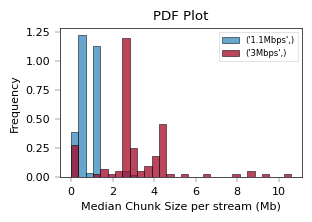

In [11]:
# plotting the median chunk sizes of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['rate'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('1.1Mbps',), Mean: 1.9939797365527738, Median: 1.9109162011173182
combo: ('3Mbps',), Mean: 2.0537184803796102, Median: 1.8854130434782612


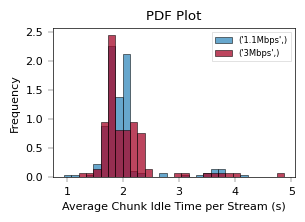

In [12]:
# plotting the average idle time of chunks in streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['rate'],
    plot_key='avg_idle_time',
    xlabel='Average Chunk Idle Time per Stream (s)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('campus',), Mean: 0.38085111077594397, Median: 0.39396926385716324
combo: ('satellite',), Mean: 1.1173108351457441, Median: 1.1240910382111318


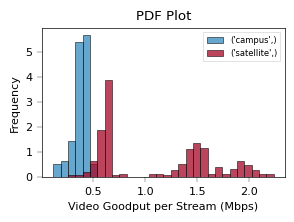

In [13]:
# plotting the throughput of streams
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('campus',), Mean: 0.7846386247294823, Median: 0.557952880859375
combo: ('satellite',), Mean: 2.33361528466894, Median: 1.59210205078125


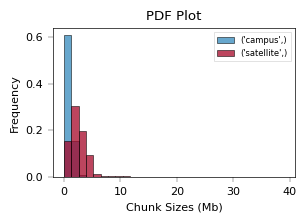

In [14]:
# plot the sizes of chunks by shaping rate
helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['network'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('IRL',), Mean: 1.9342282622877245, Median: 1.349700927734375
combo: ('MOBA',), Mean: 1.8931920748601125, Median: 1.361175537109375
combo: ('SIMMULATING',), Mean: 1.7520787394757775, Median: 1.352569580078125
combo: ('SHOOTING',), Mean: 1.677652096560292, Median: 1.343963623046875
combo: ('RPG',), Mean: 1.9330573266626443, Median: 1.355438232421875


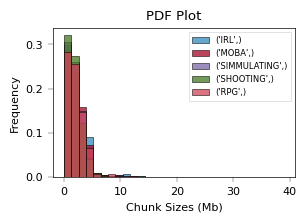

In [15]:
# plot the sizes of chunks by category
helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['category'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('IRL',), Mean: 0.9295613518043169, Median: 0.6315432351835074
combo: ('MOBA',), Mean: 0.870407209920613, Median: 0.6228687914588071
combo: ('SIMMULATING',), Mean: 0.8469311365504906, Median: 0.6153116595312574
combo: ('SHOOTING',), Mean: 0.8174171875244094, Median: 0.6138070047839537
combo: ('RPG',), Mean: 0.8918532890165917, Median: 0.6232741834481054


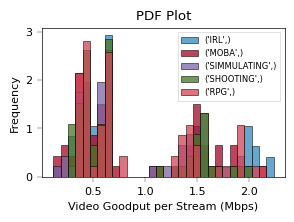

In [16]:
# plot video throughput by category
helper.plot_multiple_cdfs(
    df=main_df,
    keys=['category'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30
)

combo: ('campus',), Mean: 0.7846386247294823, Median: 0.557952880859375
combo: ('satellite',), Mean: 1.24975512171155, Median: 1.332489013671875


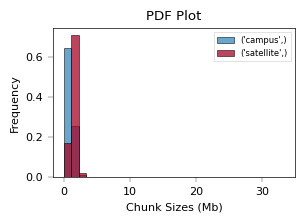

In [17]:
# plot the sizes of chunks by shaping rate
helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['network'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)

## List of graphs to generate for the direct 1.1Mbps comparisson

- [ ] plotting the median chunk sizes of streams
- [ ] plotting the average idle time of chunks in streams
- [ ] plotting the throughput of streams
- [ ] plot the sizes of chunks by shaping rate


combo: ('campus',), Mean: 0.5187384033203125, Median: 0.557952880859375
combo: ('satellite',), Mean: 1.15569970703125, Median: 1.332489013671875


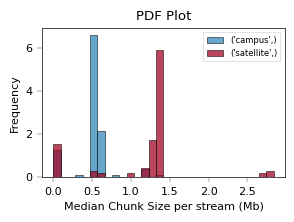

In [18]:
# plotting the median chunk sizes of streams

helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='median_chunk_size',
    xlabel='Median Chunk Size per stream (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)

combo: ('campus',), Mean: 1.9592616022830276, Median: 1.8018862934489785
combo: ('satellite',), Mean: 2.029671276456252, Median: 2.0227942857142858


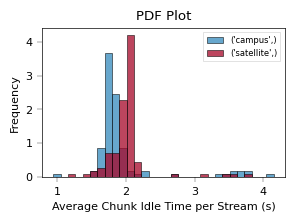

In [19]:
# plotting the average idle time of chunks in streams

helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='avg_idle_time',
    xlabel='Average Chunk Idle Time per Stream (s)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)

combo: ('campus',), Mean: 0.38085111077594397, Median: 0.39396926385716324
combo: ('satellite',), Mean: 0.6029185171001415, Median: 0.6197406994694488


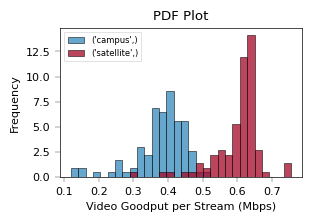

In [22]:
# plotting the throughput of streams

helper.plot_multiple_cdfs(
    df=main_df,
    keys=['network'],
    plot_key='video_goodput',
    xlabel='Video Goodput per Stream (Mbps)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)

combo: ('campus',), Mean: 0.7846386247294823, Median: 0.557952880859375
combo: ('satellite',), Mean: 1.24975512171155, Median: 1.332489013671875


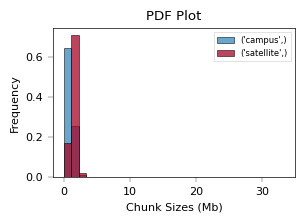

In [23]:
# plot the sizes of chunks by shaping rate

helper.plot_multiple_cdfs(
    df=per_chunk_df,
    keys=['network'],
    plot_key='size',
    xlabel='Chunk Sizes (Mb)',
    is_cdf=False,
    kde=False,
    pallete=cycler_colors,
    bins=30,
    filter_keys=['rate'],
    filter_values=['1.1Mbps']
)